In [1]:
# ==================================================
# Customer Churn EDA & Prediction
# Author: Daniel Bacon
# Date: 24th May 2025
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
# Load dataset
df = pd.read_csv("Project_Data.csv")

print("Data Shape:", df.shape)
display(df.head())

df.info()
display(df.describe())


Data Shape: (7043, 31)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [3]:
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local


In [4]:
# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

# Convert total_charges to numeric
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges'].fillna(df['total_charges'].median(), inplace=True)

# Apply feature engineering
df = feature_engineering(df)

print("✅ Feature engineering applied.")
display(df.head())


✅ Feature engineering applied.


C:\Users\danjm\AppData\Local\Temp\ipykernel_35272\870987457.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_charges'].fillna(df['total_charges'].median(), inplace=True)


,customer_id,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,...,0,1,0,0,0,0,0,0,0,0
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,1,...,0,0,0,0,0,0,0,0,0,0
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,1,...,0,0,0,1,0,0,0,1,0,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,1,...,0,0,0,1,0,1,0,1,0,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,0,...,0,1,0,1,0,0,0,1,0,1


Overall Churn Rate: 26.54%


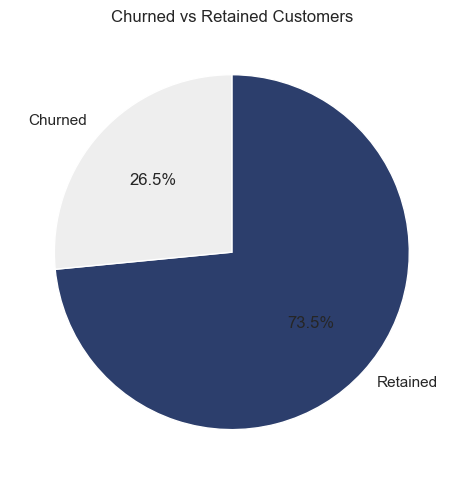

In [5]:
churn_rate = df['churn_value'].mean()
print(f"Overall Churn Rate: {churn_rate:.2%}")

# Pie chart for churn vs retained
churn_counts = df['churn_flag'].value_counts().sort_index()  # assumes 0 = retained, 1 = churned

labels = ['Retained', 'Churned']
colors = ['#2c3e6c', '#eeeeee']  # optional

plt.figure(figsize=(5, 5))
plt.pie(
    churn_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    counterclock=False
)
plt.title("Churned vs Retained Customers")
plt.tight_layout()
plt.show()


Index(['Count', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'tenure_months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Contract', 'Paperless Billing', 'Payment Method', 'monthly_charges',
       'total_charges', 'Online Security_No internet service',
       'Online Security_Yes', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Device Protection_No internet service',
       'Device Protection_Yes', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Streaming Movies_No internet service',
       'Streaming Movies_Yes'],
      dtype='object')


,Count,Gender,Senior Citizen,Partner,Dependents,tenure_months,Phone Service,Multiple Lines,Internet Service,Contract,...,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes
0,1,0,0,0,0,2,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,1,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,8,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1
3,1,1,0,1,1,28,1,1,1,0,...,0,0,0,1,0,1,0,1,0,1
4,1,0,0,0,1,49,1,1,1,0,...,0,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,0,0,0,72,1,0,2,2,...,1,0,1,0,1,0,1,0,1,0
7039,1,0,0,1,1,24,1,1,0,1,...,0,0,0,1,0,1,0,1,0,1
7040,1,1,0,1,1,72,1,1,1,1,...,0,1,0,1,0,0,0,1,0,1
7041,1,1,0,1,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1009
           1       0.67      0.51      0.58       400

    accuracy                           0.79      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC: 0.8458164023785927


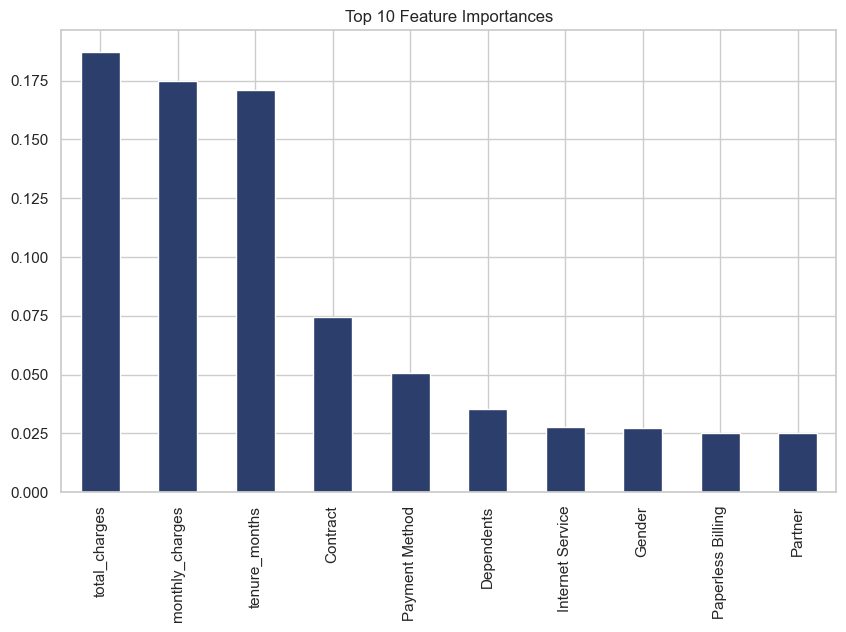

In [9]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason'
    ]

X = df.drop(columns=drop_cols, errors='ignore')
print(X.columns)
display(X)
y = df['churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances")
plt.show()


In [10]:
df['churn_probability'] = rf.predict_proba(X)[:, 1]

# Export churn risk list
df[['customer_id', 'churn_probability']].to_csv("churn_risk_list.csv", index=False)

# Export top 500 likely churners
top_500 = df.nlargest(500, 'churn_probability')
top_500[['customer_id', 'churn_probability']].to_csv("top_500_churn_customers.csv", index=False)

print("Exported churn_risk_list.csv and top_500_churn_customers.csv")


Exported churn_risk_list.csv and top_500_churn_customers.csv
